<a href="https://colab.research.google.com/github/abhilb/DicomImageClassification/blob/main/Build_a_VGG16_Model_Milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Dicom Image Classification

# Workflow

1. Load the XRAY image dataset, define paths to the datasets, including path to COVID and Non-COVID data.

2. Open and display a random set of 9 images (COVID and non-COVID) from the XRAY image dataset.

3. Resize all images to 224x224 pixels.

4. Plot label distribution of images- that is how many images per label for XRAY image dataset.

5. Estimate image statistics- mean, max, min, standard deviation of pixel values in X-ray images.

6. Plot histogram of image intensities for COVID and Non-COVID images from the XRAY image dataset.

7. Compare histograms of COVID and Non-COVID images. How do they differ? What information do you get from the histograms?

8. Convert all images from the COVID and Non-COVID directories in DICOM (.dcm) format.

9. Save all file paths with their class labels to a CSV file.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random
import pandas as pd
from itertools import chain
from collections import defaultdict
from imageio import imread
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import trange
from pathlib import Path

## Step 1. Load the XRAY image dataset, define paths to the datasets, including path to COVID and NON-COVID data.

In [3]:
!unzip -o '/content/gdrive/MyDrive/Colab Notebooks/content/COVID-19_Radiography_Database.zip'

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6723.png  
  inflating:

In [4]:
NORMAL_IMAGES_PATH = Path('COVID-19_Radiography_Dataset/Normal/')
COVID_IMAGES_PATH = Path('COVID-19_Radiography_Dataset/COVID/')

## Step 2. Open and display a random set of 9 images (COVID and non-COVID) from the XRAY image dataset.

In [5]:
dataset = defaultdict(list)
for img_name in chain(NORMAL_IMAGES_PATH.rglob('*.png'), COVID_IMAGES_PATH.rglob('*.png')):
  label = img_name.parent.stem.upper()
  fname = img_name
  dataset['label'].append(label)
  dataset['path'].append(fname)
df = pd.DataFrame(dataset)

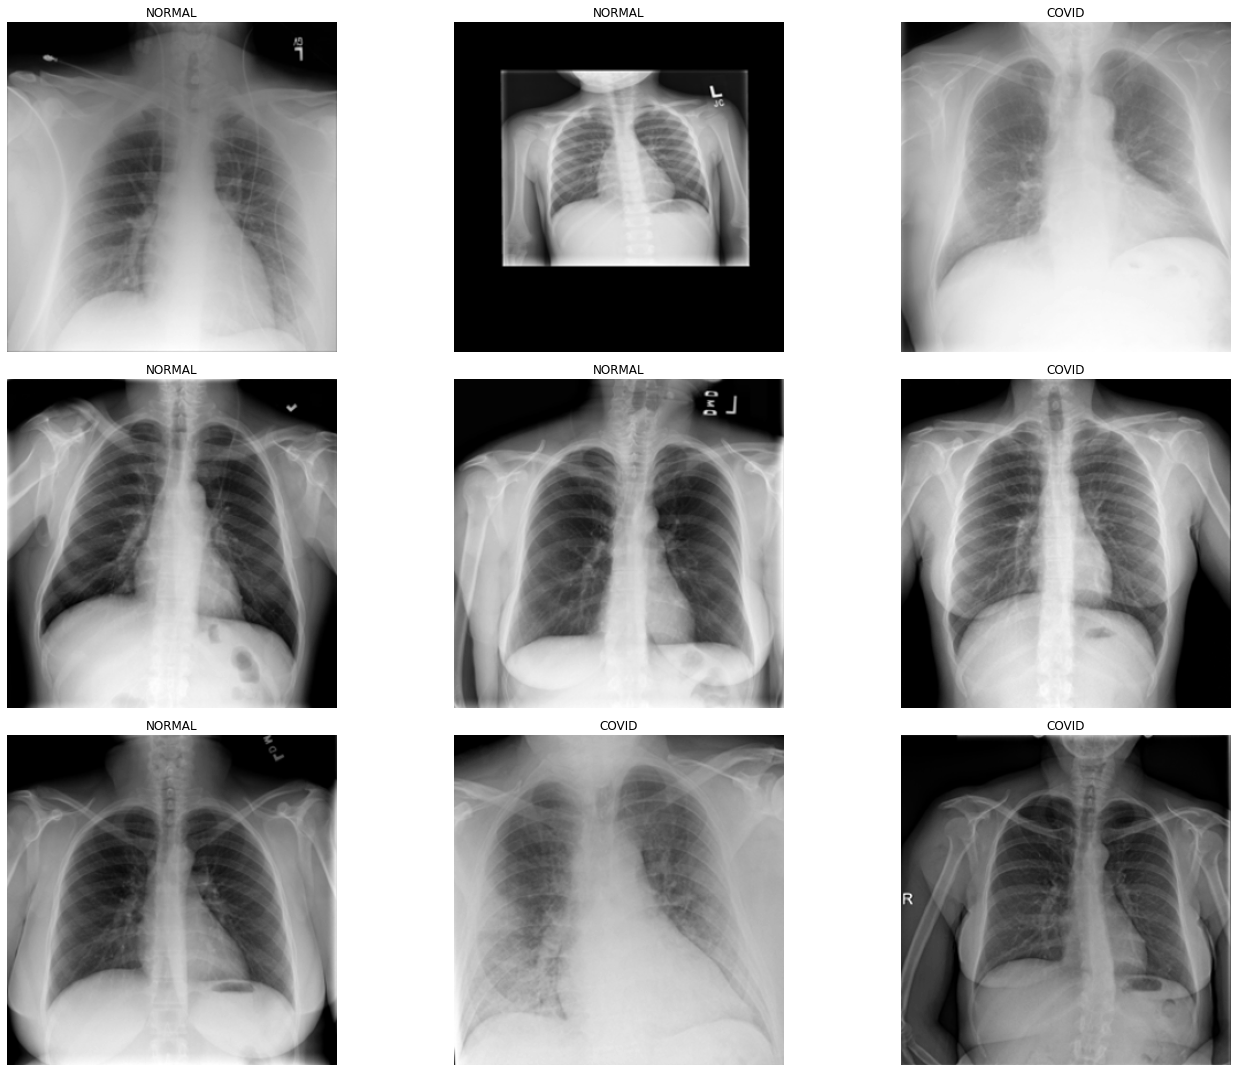

In [6]:
normal_samples = df[df.label == 'NORMAL'].sample(5)
covid_samples = df[df.label == 'COVID'].sample(5)
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(20, 15)
img_iter = chain(normal_samples.iterrows(), covid_samples.iterrows())

for r in range(3):
  for c in range(3):
    _, fname_col = next(img_iter)
    axs[c, r].imshow(imread(fname_col.path), cmap='gray')
    axs[c, r].set_title(fname_col.label)   
    axs[c, r].axis('off')

plt.tight_layout()
plt.show()

## Step 3. Resize all images to 224x224 pixels.

In [7]:
for img_name in tqdm(chain(NORMAL_IMAGES_PATH.rglob('*.png'), COVID_IMAGES_PATH.rglob('*.png'))):
  img = Image.open(img_name)
  img = img.resize((224, 224), Image.ANTIALIAS)
  img.save(img_name)

13808it [02:41, 85.37it/s]


## Step 4. Plot label distribution of images- that is how many images per label for XRAY image dataset.



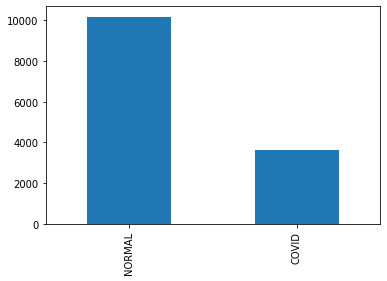

In [8]:
df['label'].value_counts().plot(kind='bar')
plt.show()

## Step 5. Estimate image statistics- mean, max, min, standard deviation of pixel values in X-ray images.

In [9]:
num_of_imgs = df.label.value_counts().sum()
img_data = np.empty((224, 224, num_of_imgs))
normal_samples = df[df.label == 'NORMAL']
covid_samples = df[df.label == 'COVID']

img_iter = chain(normal_samples.iterrows(), covid_samples.iterrows())
for idx in trange(num_of_imgs):
  _, img_fname = next(img_iter)
  img_data[:, :, idx] = imread(img_fname.path)  
img_data.shape

(224, 224, 13808)

In [10]:
print(f"Mean value of pixel values: {img_data.mean()}")
print(f"Maximum value of pixel values: {img_data.max()}")
print(f"Minimum value of pixel values: {img_data.min()}")
print(f"Standard deviation value of pixel values: {img_data.std()}")
del img_data

Mean value of pixel values: 132.05183432186607
Maximum value of pixel values: 255.0
Minimum value of pixel values: 0.0
Standard deviation value of pixel values: 65.2490469756534


## Step 6. Plot histogram of image intensities for COVID and Non-COVID images from the XRAY image dataset.

In [11]:
normal_samples = df[df.label == 'NORMAL']
normal_samples_count = normal_samples.path.count()
covid_samples = df[df.label == 'COVID']
covid_samples_count = covid_samples.path.count()
normal_img_data = np.empty((224, 224, normal_samples_count))
covid_img_data = np.empty((224, 224, covid_samples_count))

for idx in trange(normal_samples_count):
  normal_img_data[:, :, idx] = imread(normal_samples.iloc[idx].path)

for idx in trange(covid_samples_count):
  covid_img_data[:, :, idx] = imread(covid_samples.iloc[idx].path)


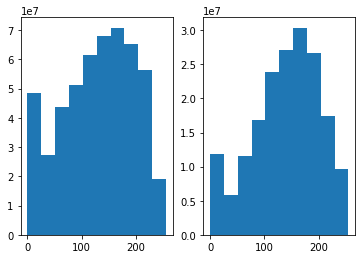

In [12]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(normal_img_data.ravel())
ax[1].hist(covid_img_data.ravel())
plt.show()

## Step 7. Compare histograms of COVID and Non-COVID images. How do they differ? What information do you get from the histograms?



* Both the histograms looks similar. 
* It will not be possible to distinguish between covid and non covid images based on image pixel value statistics

## Step 8. Convert all images from the COVID and Non-COVID directories in DICOM (.dcm) format.

In [13]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 80kB/s 


In [14]:
import SimpleITK as sitk
normal_dir =  Path('/content/gdrive/MyDrive/Colab Notebooks/content/') / "normal"
normal_dir.mkdir(exist_ok = True)
for idx in trange(normal_samples_count):
  img = normal_img_data[:, :, idx].astype(np.int8)
  dicom_img = sitk.GetImageFromArray(img)
  fname = str(normal_dir / f"{idx:03d}.dcm")
  sitk.WriteImage(dicom_img, fname)

In [15]:
covid_dir =  Path('/content/gdrive/MyDrive/Colab Notebooks/content/') / "covid"
covid_dir.mkdir(exist_ok = True)
for idx in trange(covid_samples_count):
  img = covid_img_data[:, :, idx].astype(np.int8)
  dicom_img = sitk.GetImageFromArray(img)
  fname = str(covid_dir / f"{idx:03d}.dcm")
  sitk.WriteImage(dicom_img, fname)


## Step 9. Save all file paths with their class labels to a CSV file.

In [16]:
with open("dataset.csv", "w") as csv_file:
  csv_writer = csv.writer(csv_file)
  for fname in covid_dir.rglob("*.dcm"):
    csv_writer.writerow([fname, "COVID"])
  for fname in normal_dir.rglob("*.dcm"):
    csv_writer.writerow([fname, "NORMAL"])